In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm import tqdm

/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


In [2]:
%%time
root = '../input/ashrae-energy-prediction/'
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
weather_train_df["timestamp"] = pd.to_datetime(weather_train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
test_df = pd.read_csv(root + 'test.csv')
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather_test_df = pd.read_csv(root + 'weather_test.csv')
weather_test_df["timestamp"] = pd.to_datetime(weather_test_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

CPU times: user 50.6 s, sys: 11.2 s, total: 1min 1s
Wall time: 1min


In [3]:
print('Size of train_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)


In [4]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
## Reducing memory
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [6]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int16
meter            int8
timestamp        datetime64[ns]
meter_reading    float32
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB


In [8]:
train_df.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,1.988706e+03
std,4.269133e+02,9.309921e-01,1.532159e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


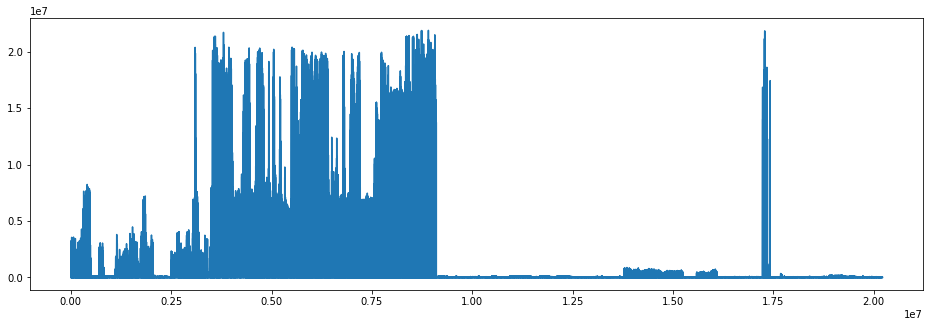

In [9]:
plt.figure(figsize = (16,5))
plt.plot(train_df['meter_reading'])

In [10]:
train_df.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [11]:
# No. of unique values in building id
train_df.building_id.nunique()

1449

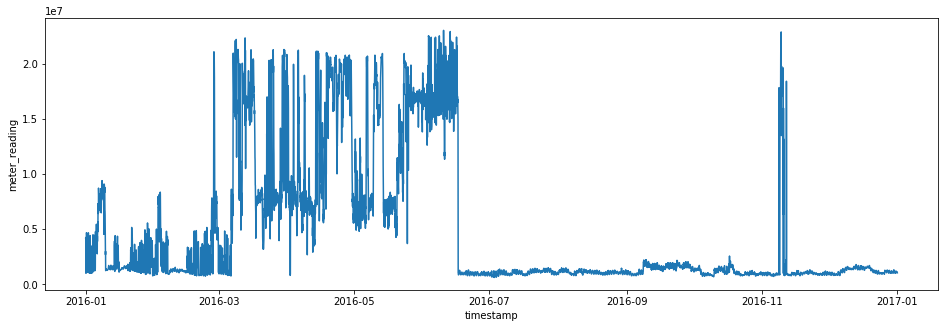

In [12]:
date_meter_reading = train_df.groupby(['timestamp'])['meter_reading'].sum()
plt.figure(figsize = (16,5))
plt.xlabel("timestamp")
plt.ylabel("meter_reading")
plt.plot(date_meter_reading)

In [13]:
date_mtype_reading = train_df.groupby(['timestamp', 'meter'])['meter_reading'].agg(['min','max','median','sum'])
date_mtype_reading.columns = ['meter_reading_' + x for x in date_mtype_reading.columns]
date_mtype_reading.reset_index(inplace=True)
date_mtype_reading['Date'] = date_mtype_reading.timestamp.dt.date
date_mtype_reading.head()

,timestamp,meter,meter_reading_min,meter_reading_max,meter_reading_median,meter_reading_sum,Date
0,2016-01-01 00:00:00,0,0.0,4.791840e+03,29.065250,1.467970e+05,2016-01-01
1,2016-01-01 00:00:00,1,0.0,5.778910e+03,0.105500,5.239657e+04,2016-01-01
2,2016-01-01 00:00:00,2,0.0,3.241630e+06,385.429016,3.924435e+06,2016-01-01
3,2016-01-01 00:00:00,3,0.0,2.821590e+04,99.822052,8.765517e+04,2016-01-01
4,2016-01-01 01:00:00,0,0.0,4.855520e+03,40.605999,1.664396e+05,2016-01-01


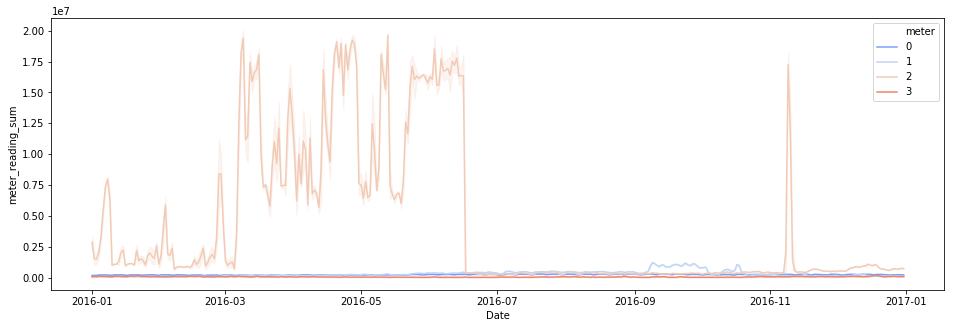

In [14]:
plt.figure(figsize = (16,5))
sns.lineplot(x="Date", 
             y="meter_reading_sum", 
             hue="meter", 
             data=date_mtype_reading, 
             palette=sns.color_palette('coolwarm', n_colors=4))

{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}
What is the difference between steam and hotwater, in terms of usage in building and for meter reading?

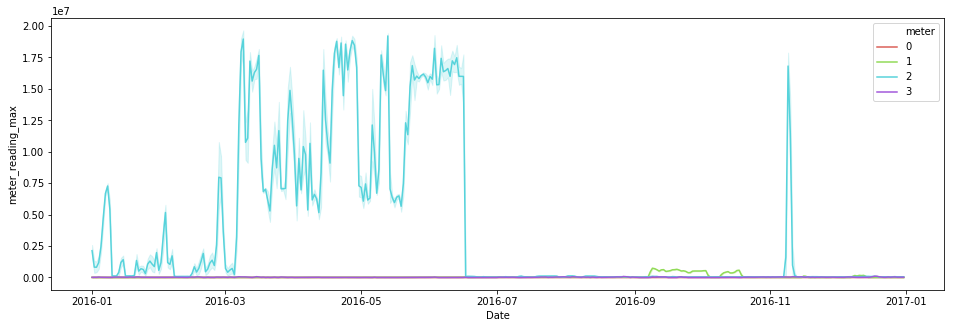

In [15]:
plt.figure(figsize = (16,5))
sns.lineplot(x="Date", 
             y="meter_reading_max", 
             hue="meter", 
             data=date_mtype_reading, 
             palette=sns.color_palette('hls', n_colors=4))

Most of the spikes are caused because of the maximum meter readings for each building. Lets try to plot median, which will give a clear picture

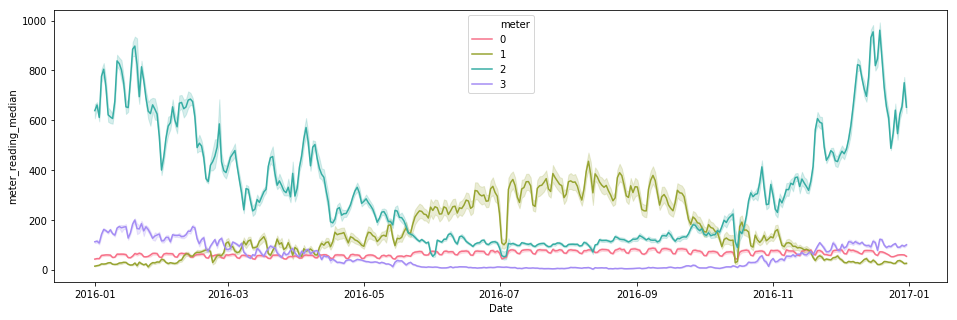

In [16]:
plt.figure(figsize = (16,5))
sns.lineplot(x="Date", 
             y="meter_reading_median", 
             hue="meter", 
             data=date_mtype_reading, 
             palette=sns.color_palette('husl', n_colors=4))

Find what's the difference between values(variance or std) in meter_reading for a particular date. Although, median gives a clear picture, still want to confirm the numbers. OR plot the meter reading(scatter plot) for few dates and see the numbers. If the SD is less, we are good, else, this approach doesn't yield correct numbers.

In [17]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [18]:
building_meta_df.shape

(1449, 6)

In [19]:
building_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int8
building_id    1449 non-null int16
primary_use    1449 non-null object
square_feet    1449 non-null int32
year_built     675 non-null float16
floor_count    355 non-null float16
dtypes: float16(2), int16(1), int32(1), int8(1), object(1)
memory usage: 27.0+ KB


In [20]:
building_meta_df.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [21]:
building_meta_df.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.0000,355.000000
mean,6.952381,724.000000,92111.776398,inf,3.740234
std,5.003432,418.434583,110769.950997,31.0625,3.333984
min,0.000000,0.000000,283.000000,1900.0000,1.000000
25%,3.000000,362.000000,23012.000000,1949.0000,1.000000
50%,5.000000,724.000000,57673.000000,1970.0000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.0000,5.000000
max,15.000000,1448.000000,875000.000000,2017.0000,26.000000


mean() of year_built is inf because sum is inf. Since, we have changed the dtype of columns to save memory usage, the sum() is coming out of range of float16.

In [22]:
# Types of building in the data
building_meta_df['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

**UNIVARIATE ANALYSIS**

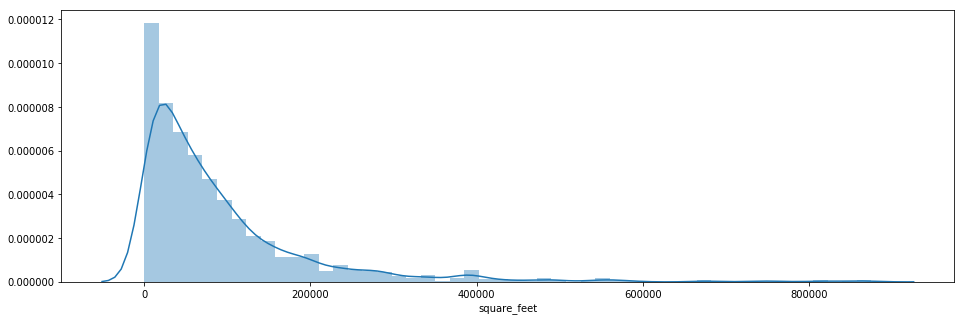

In [23]:
plt.figure(figsize = (16,5))
sns.distplot(building_meta_df.square_feet)

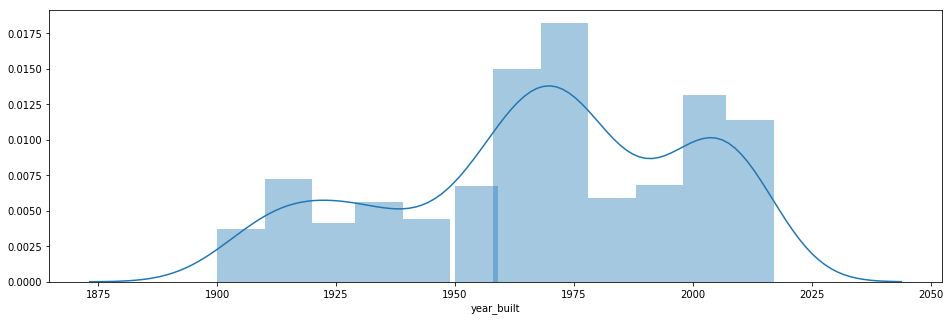

In [24]:
# Year built is the year building is opened, as per the kaggle information
building_meta_df_temp = building_meta_df[pd.notnull(building_meta_df.year_built)]
plt.figure(figsize = (16,5))
sns.distplot(building_meta_df_temp.year_built)

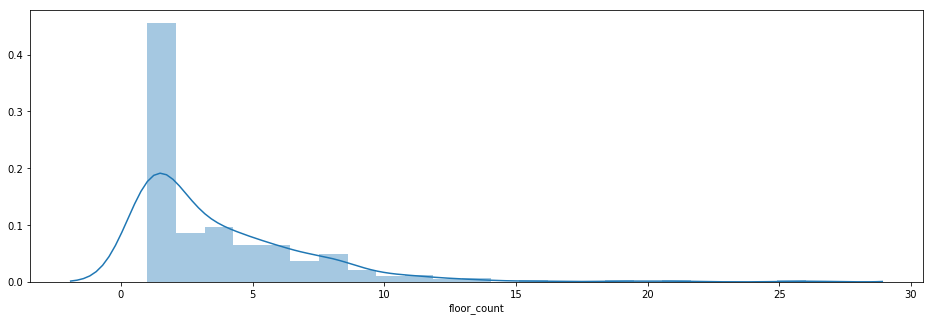

In [25]:
building_meta_df_temp = building_meta_df[pd.notnull(building_meta_df.floor_count)]
plt.figure(figsize = (16,5))
sns.distplot(building_meta_df_temp.floor_count)

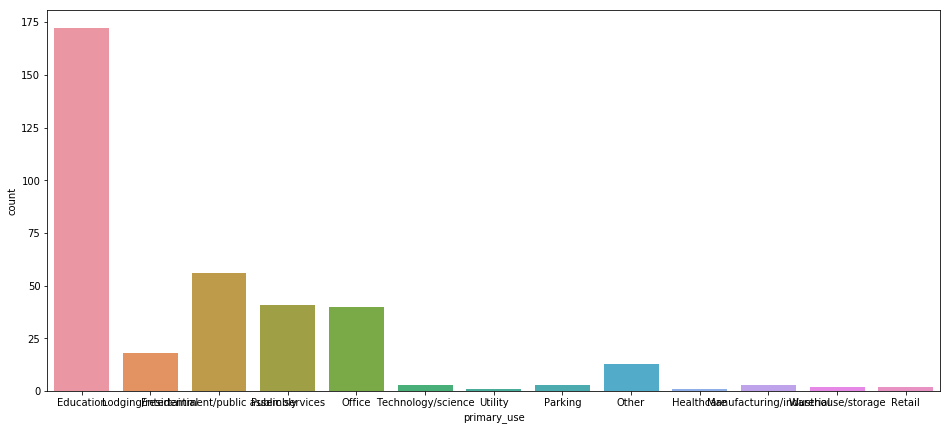

In [26]:
plt.figure(figsize = (16,7))
use_plot = sns.countplot(building_meta_df_temp.primary_use)

In [27]:
# Check no. of buildings for each building type
building_meta_df_temp.primary_use.value_counts()

Education                        172
Entertainment/public assembly     56
Public services                   41
Office                            40
Lodging/residential               18
Other                             13
Manufacturing/industrial           3
Parking                            3
Technology/science                 3
Warehouse/storage                  2
Retail                             2
Healthcare                         1
Utility                            1
Name: primary_use, dtype: int64

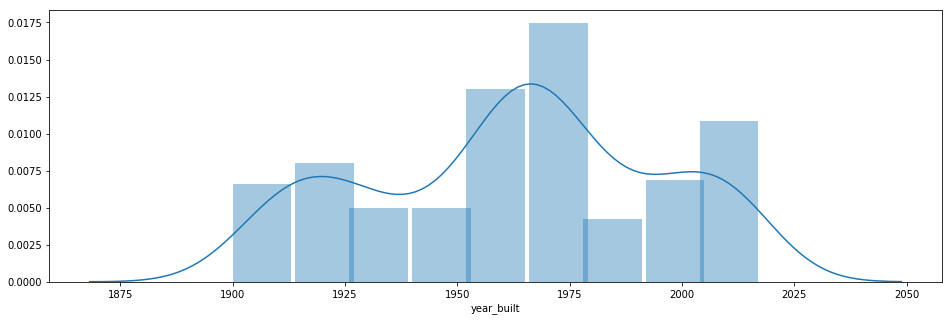

In [28]:
# Year built is the year building is opened, as per the kaggle information
building_meta_df_temp = building_meta_df[pd.notnull(building_meta_df.year_built)]
plt.figure(figsize = (16,5))
sns.distplot(building_meta_df_temp[building_meta_df_temp.primary_use == "Education"].year_built)

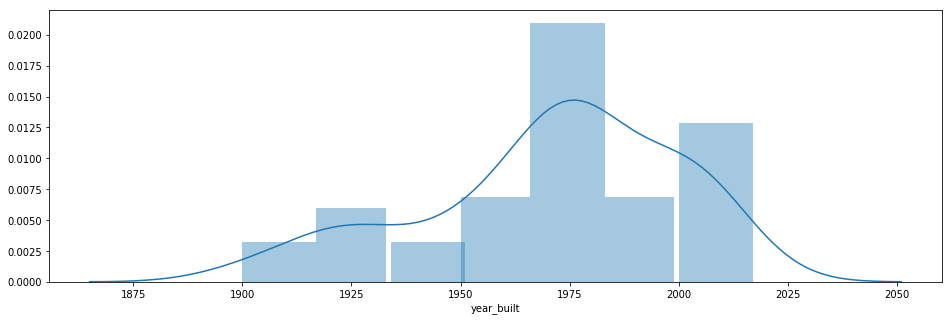

In [29]:
plt.figure(figsize = (16,5))
sns.distplot(building_meta_df_temp[building_meta_df_temp.primary_use == "Entertainment/public assembly"].year_built)

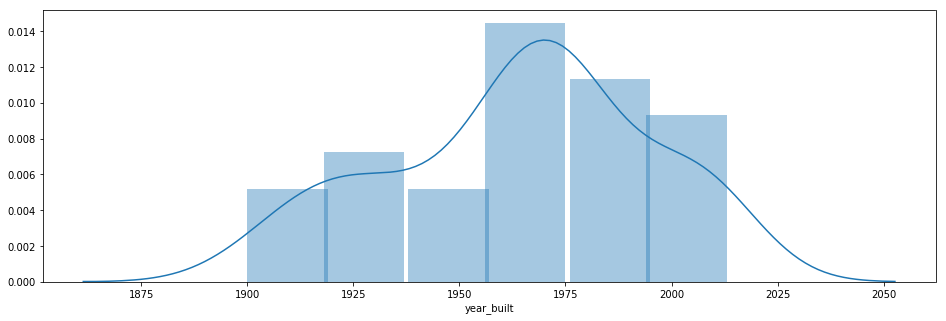

In [30]:
plt.figure(figsize = (16,5))
sns.distplot(building_meta_df_temp[building_meta_df_temp.primary_use == "Public services"].year_built)

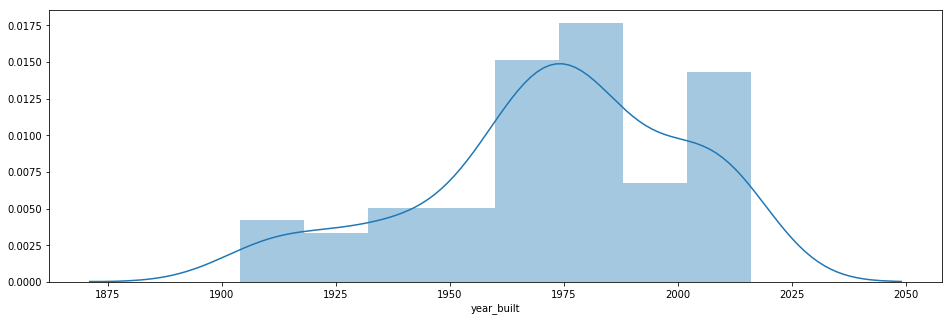

In [31]:
plt.figure(figsize = (16,5))
sns.distplot(building_meta_df_temp[building_meta_df_temp.primary_use == "Office"].year_built)

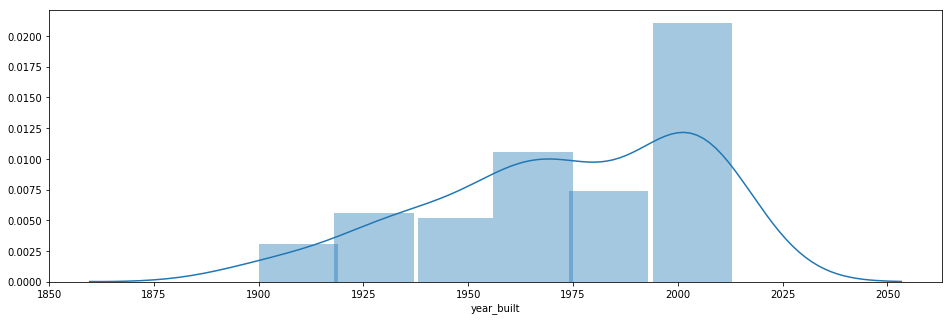

In [32]:
plt.figure(figsize = (16,5))
sns.distplot(building_meta_df_temp[building_meta_df_temp.primary_use == "Lodging/residential"].year_built)

The boom in the real estate industry(especially for resindential purposes) that came during 2000s, is shown by the graph.

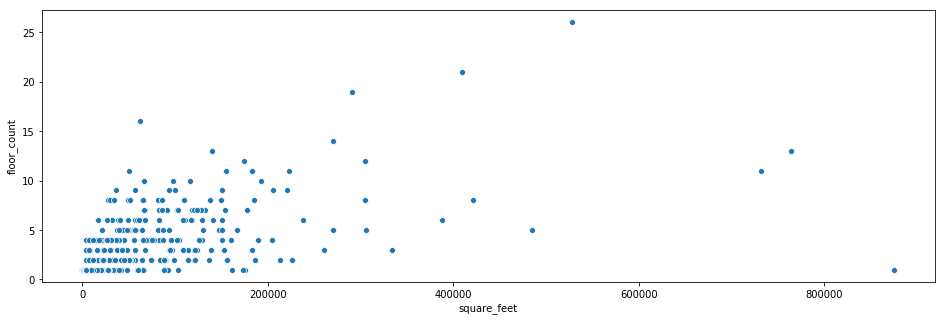

In [33]:
plt.figure(figsize = (16,5))
sns.scatterplot(x="square_feet", y="floor_count", data=building_meta_df)

Most of the buildings below 2,00,000 square feet have floor count within range of 10. Can be used to impute missing values.

In [34]:
building_meta_df.corr()

,site_id,building_id,square_feet,year_built,floor_count
site_id,1.000000,0.977283,0.082136,-0.187021,-0.468542
building_id,0.977283,1.000000,0.074312,-0.230185,-0.482477
square_feet,0.082136,0.074312,1.000000,0.109063,0.530298
year_built,-0.187021,-0.230185,0.109063,1.000000,0.099393
floor_count,-0.468542,-0.482477,0.530298,0.099393,1.000000


No strong co-relations between any of the independent variables in building_meta dataframe.

In [35]:
building_type_df = building_meta_df.groupby(['primary_use'])['square_feet','year_built', 'floor_count'].agg(['mean','max','min'])
building_type_df.head()

square_feet                year_built  \
                                        mean     max    min       mean   
primary_use                                                              
Education                      104329.000000  764237   2010     1963.0   
Entertainment/public assembly   80584.070652  875000    356     1971.0   
Food sales and service          38485.000000   69876  24867     2012.0   
Healthcare                     140480.869565  819577   9813     1982.0   
Lodging/residential             85368.605442  745671   2000     1973.0   

                                              floor_count             
                                  max     min        mean   max  min  
primary_use                                                           
Education                      2017.0  1900.0    4.734375  26.0  1.0  
Entertainment/public assembly  2016.0  1900.0    2.089844   9.0  1.0  
Food sales and service         2012.0  2012.0         NaN   NaN  NaN  
Healthcare                     2014.0  1922.0    1.000000   1.0  1.0  
Lodging/residential            2013.0  1900.0    6.332031  16.0  1.0

In [36]:
building_type_df.columns = [building_type_df.columns[i][0] + '_' + building_type_df.columns[i][1] for i in range(0,len(building_type_df.columns))]

In [37]:
# Fill index of 'Food sales and service'
building_type_df.fillna(1, inplace=True)

In [38]:
for i in range(0,len(building_meta_df)):
    if(pd.isna(building_meta_df['year_built'][i])):
        building_meta_df.loc[i,'year_built'] = building_type_df.loc[building_meta_df['primary_use'][i], 'year_built_mean']
    if(pd.isna(building_meta_df['floor_count'][i])):
        building_meta_df.loc[i,'floor_count'] = building_type_df.loc[building_meta_df['primary_use'][i], 'floor_count_mean']

In [39]:
# Check null values
building_meta_df.isnull().sum()

site_id        0
building_id    0
primary_use    0
square_feet    0
year_built     0
floor_count    0
dtype: int64

In [40]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [41]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float16
cloud_coverage        70600 non-null float16
dew_temperature       139660 non-null float16
precip_depth_1_hr     89484 non-null float16
sea_level_pressure    129155 non-null float16
wind_direction        133505 non-null float16
wind_speed            139469 non-null float16
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB


In [42]:
weather_train_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.0,139660.000000,89484.0,129155.0,133505.0,139469.000000
mean,7.478977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.604744,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
min,0.000000,-28.906250,0.0,-35.000000,-1.0,968.0,0.0,0.000000
25%,3.000000,7.199219,0.0,0.600098,0.0,1012.0,80.0,2.099609
50%,7.000000,15.000000,2.0,8.296875,0.0,1016.5,190.0,3.099609
75%,11.000000,22.203125,4.0,14.398438,0.0,1021.0,280.0,5.000000
max,15.000000,47.187500,9.0,26.093750,343.0,1046.0,360.0,19.000000


In [43]:
# Get unique count of site id's in the data
weather_train_df.site_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [44]:
weather_train_df.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

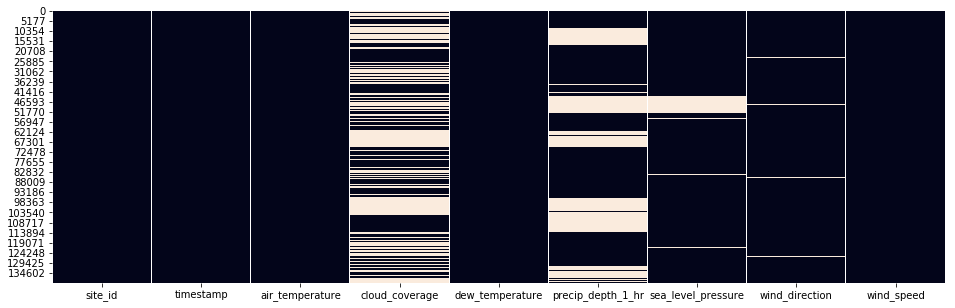

In [45]:
# To check occurence of missing values
plt.figure(figsize=(16,5))
sns.heatmap(weather_train_df.isnull(), cbar=False)

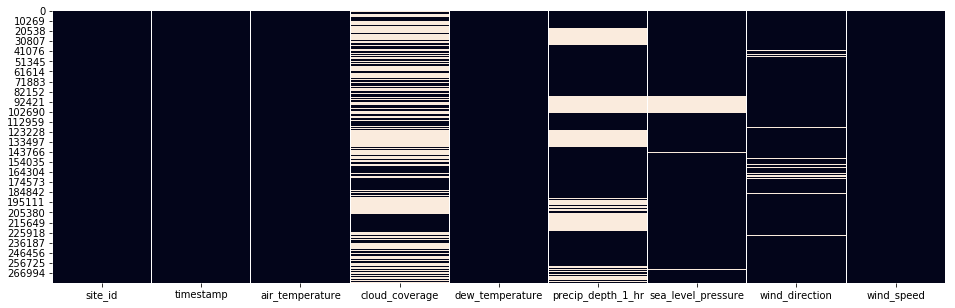

In [46]:
# To check occurence of missing values
plt.figure(figsize=(16,5))
sns.heatmap(weather_test_df.isnull(), cbar=False)

In [47]:
weather_train_df.corr()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,1.000000,-0.262746,0.021003,-0.204501,0.020269,-0.009093,0.045021,0.027689
air_temperature,-0.262746,1.000000,0.010150,0.790383,-0.010717,-0.209275,-0.093240,-0.056736
cloud_coverage,0.021003,0.010150,1.000000,0.183606,0.122253,-0.158422,0.052560,0.294019
dew_temperature,-0.204501,0.790383,0.183606,1.000000,0.065882,-0.168677,-0.149031,-0.096831
precip_depth_1_hr,0.020269,-0.010717,0.122253,0.065882,1.000000,-0.081386,-0.013161,0.035024
sea_level_pressure,-0.009093,-0.209275,-0.158422,-0.168677,-0.081386,1.000000,-0.102913,-0.251605
wind_direction,0.045021,-0.093240,0.052560,-0.149031,-0.013161,-0.102913,1.000000,0.354697
wind_speed,0.027689,-0.056736,0.294019,-0.096831,0.035024,-0.251605,0.354697,1.000000


In [48]:
# Get a date column from timestamp column
weather_train_date_df = weather_train_df.copy()
weather_train_date_df['Date'] = weather_train_df['timestamp'].dt.date

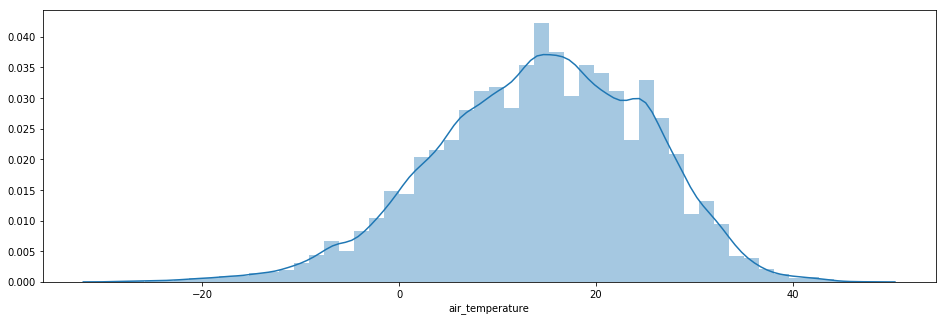

In [49]:
weather_train_df_temp = weather_train_df[pd.notnull(weather_train_df.air_temperature)]
plt.figure(figsize = (16,5))
sns.distplot(weather_train_df_temp.air_temperature)

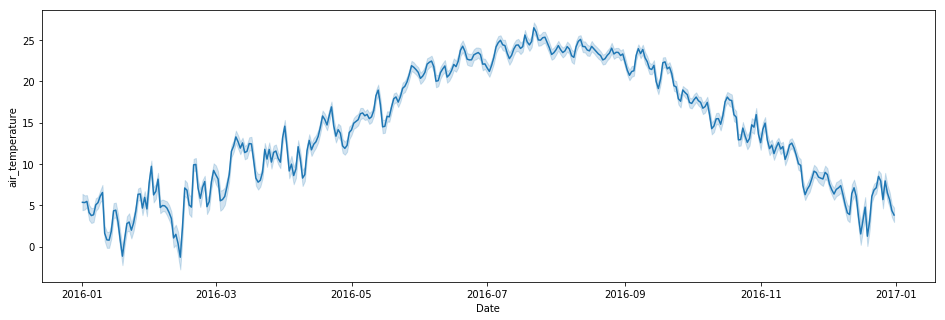

In [50]:
plt.figure(figsize = (16,5))
sns.lineplot(x="Date", 
             y="air_temperature", 
             data=weather_train_date_df, 
             palette=sns.color_palette('husl', n_colors=4))

This graph is in line with train_df data. Because, as the air temperature increased, meter reading for chilled water got increase, while as the temperature decrease, meter reading for hot water and specially steam increased.
Winter Season - 2016-01 to 2016-05 & 2016-10 to 2017-01
summer - 2016-05 to 2016-10


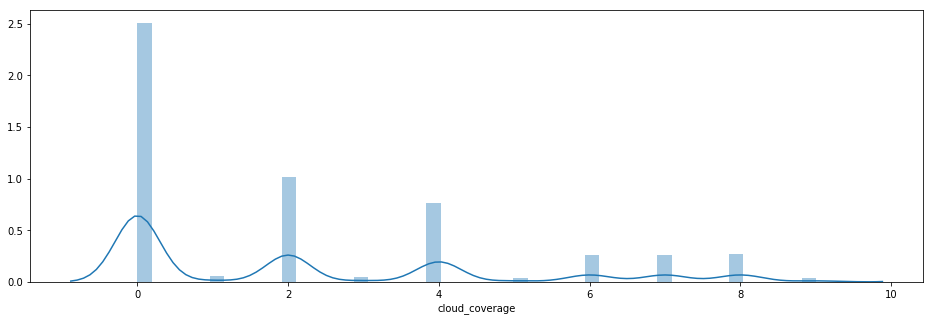

In [51]:
weather_train_df_temp = weather_train_df[pd.notnull(weather_train_df.cloud_coverage)]
plt.figure(figsize = (16,5))
sns.distplot(weather_train_df_temp.cloud_coverage)

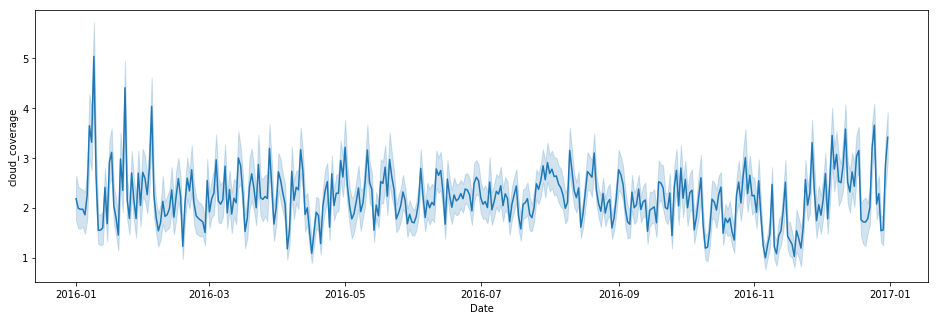

In [52]:
plt.figure(figsize = (16,5))
sns.lineplot(x="Date", 
             y="cloud_coverage", 
             data=weather_train_date_df, 
             palette=sns.color_palette('hls', n_colors=4))

Cloud coverage is almost constant with spikes ranging from 2 to 3 except for a few cases. Means, it might be partly sunny always, given the weather conditions.
FEW = Few (1 to 2 oktas); SCT = Scattered (3 to 4 oktas)

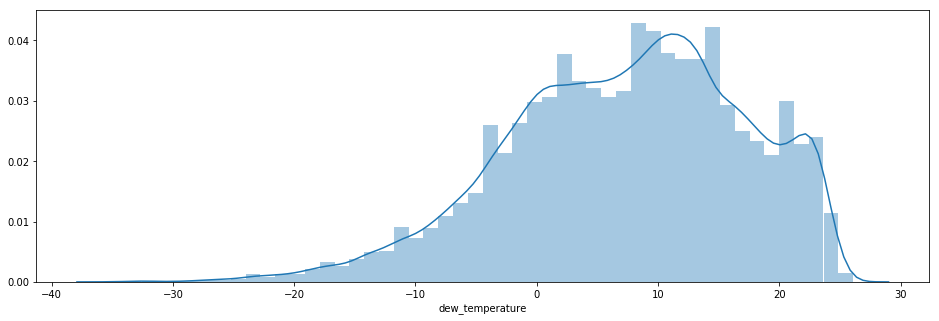

In [53]:
weather_train_df_temp = weather_train_df[pd.notnull(weather_train_df.dew_temperature)]
plt.figure(figsize = (16,5))
sns.distplot(weather_train_df_temp.dew_temperature)

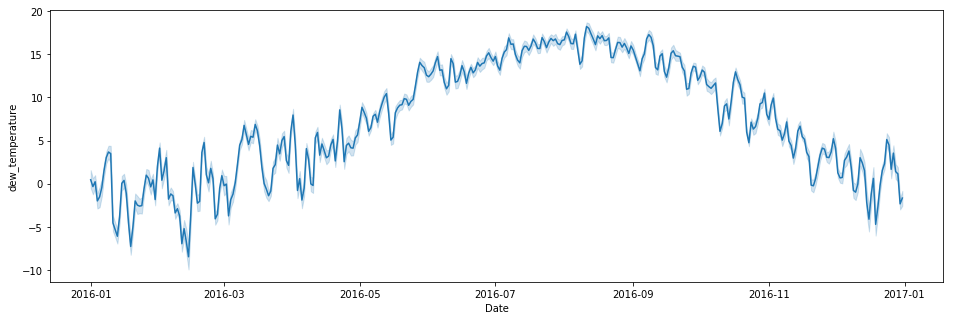

In [54]:
plt.figure(figsize = (16,5))
sns.lineplot(x="Date", 
             y="dew_temperature", 
             data=weather_train_date_df, 
             palette=sns.color_palette('hls', n_colors=4))

Information: The dewpoint temperature is the temperature at which the air can no longer "hold" all of the water vapor which is mixed with it, and some of the water vapor must condense into liquid water. The dew point is always lower than (or equal to) the air temperature.

If the air temperature cools to the dew point, or if the dew point rises to equal the air temperature, then dew, fog or clouds begin to form. At this point where the dew point temperature equals the air temperature, the relative humidity is 100%.

Take away: Can include relative humidity column from air temperature and dew temperature.

In [55]:
len(weather_train_df.precip_depth_1_hr.unique())

129

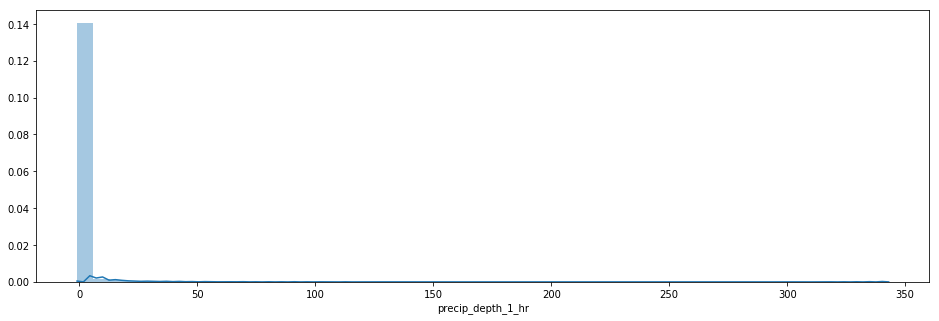

In [56]:
weather_train_df_temp = weather_train_df[pd.notnull(weather_train_df.precip_depth_1_hr)]
plt.figure(figsize = (16,5))
sns.distplot(weather_train_df_temp.precip_depth_1_hr)

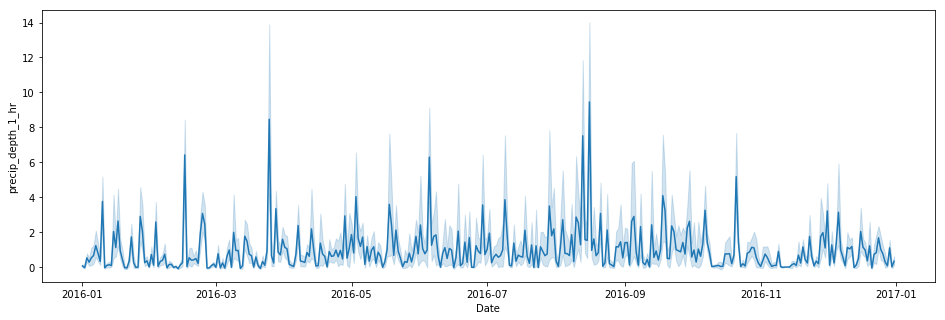

In [57]:
plt.figure(figsize = (16,5))
sns.lineplot(x="Date", 
             y="precip_depth_1_hr", 
             data=weather_train_date_df, 
             palette=sns.color_palette('hls', n_colors=4))

The spikes might indicate that rain fall happened. Can look into the picture by plotting values of relative humidity. Should show same behaviour.

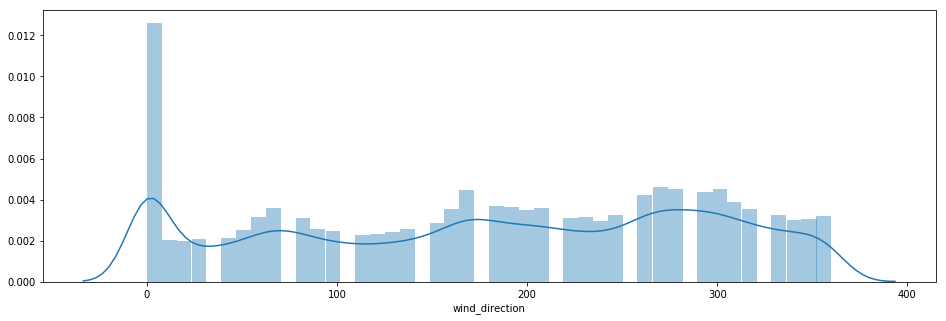

In [58]:
weather_train_df_temp = weather_train_df[pd.notnull(weather_train_df.wind_direction)]
plt.figure(figsize = (16,5))
sns.distplot(weather_train_df_temp.wind_direction)

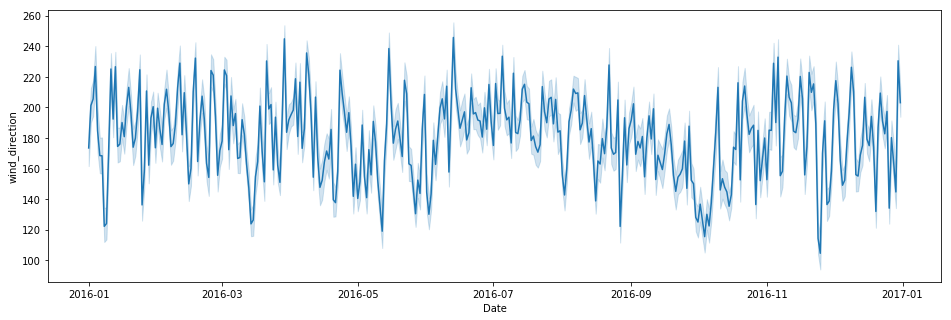

In [59]:
plt.figure(figsize = (16,5))
sns.lineplot(x="Date", 
             y="wind_direction", 
             data=weather_train_date_df, 
             palette=sns.color_palette('hls', n_colors=4))

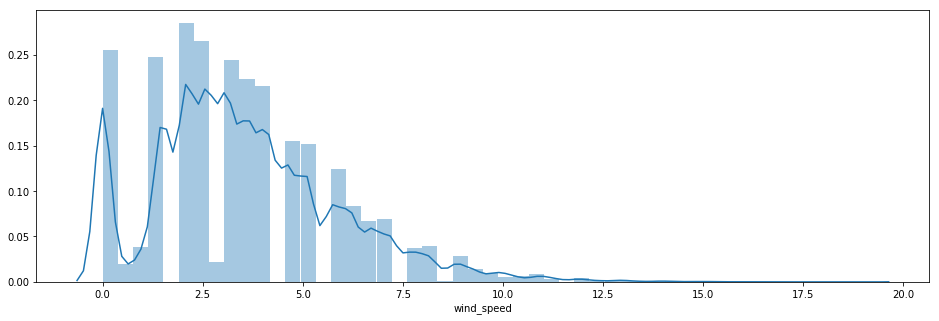

In [60]:
weather_train_df_temp = weather_train_df[pd.notnull(weather_train_df.wind_speed)]
plt.figure(figsize = (16,5))
sns.distplot(weather_train_df_temp.wind_speed)

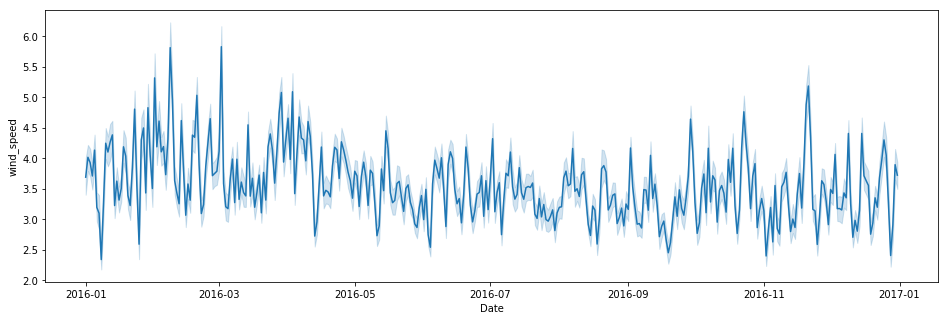

In [61]:
plt.figure(figsize = (16,5))
sns.lineplot(x="Date", 
             y="wind_speed", 
             data=weather_train_date_df, 
             palette=sns.color_palette('hls', n_colors=4))

In [62]:
# Fill the missing values using linear interpolation method in forward direction
weather_train_df.interpolate(method='linear', limit_direction='forward', inplace=True)

In [63]:
# Fill the missing values using linear interpolation method in backward direction to fill left-over values
weather_train_df.interpolate(method='linear', limit_direction='backward', inplace=True)

In [64]:
# Join the train and building dataframes
train_building_df = train_df.merge(building_meta_df, on=['building_id'], how='left')
train_building_df.shape

(20216100, 9)

In [65]:
train_building_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,4.734375
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,4.734375
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,4.734375
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,4.734375
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,4.734375


In [66]:
train_building_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 9 columns):
building_id      int16
meter            int8
timestamp        datetime64[ns]
meter_reading    float32
site_id          int8
primary_use      object
square_feet      int32
year_built       float16
floor_count      float16
dtypes: datetime64[ns](1), float16(2), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 771.2+ MB


In [67]:
train_building_df.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
site_id          0
primary_use      0
square_feet      0
year_built       0
floor_count      0
dtype: int64

In [68]:
train_final_df = train_building_df.merge(weather_train_df, on=['timestamp', 'site_id'], how='left')
train_final_df.shape

(20216100, 16)

In [69]:
train_final_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,4.734375,25.0,6.0,20.0,-1.0,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,4.734375,25.0,6.0,20.0,-1.0,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,4.734375,25.0,6.0,20.0,-1.0,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,4.734375,25.0,6.0,20.0,-1.0,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,4.734375,25.0,6.0,20.0,-1.0,1019.5,0.0,0.0


In [70]:
train_final_df.isnull().sum()

building_id               0
meter                     0
timestamp                 0
meter_reading             0
site_id                   0
primary_use               0
square_feet               0
year_built                0
floor_count               0
air_temperature       90495
cloud_coverage        90495
dew_temperature       90495
precip_depth_1_hr     90495
sea_level_pressure    90495
wind_direction        90495
wind_speed            90495
dtype: int64

Check for which timestamp and site id, values are not present in weather_data but present in training data

In [71]:
train_final_df.fillna(0, inplace=True)

In [72]:
train_final_df_temp = train_final_df.groupby('primary_use')['meter_reading'].agg(sum)
train_final_df_temp.sort_values(ascending=False)

primary_use
Education                        3.743959e+10
Office                           2.313915e+09
Entertainment/public assembly    1.073300e+09
Lodging/residential              6.003741e+08
Public services                  4.792894e+08
Services                         3.970278e+08
Healthcare                       2.943511e+08
Parking                          3.621422e+07
Manufacturing/industrial         3.594097e+07
Food sales and service           3.478696e+07
Other                            3.359711e+07
Utility                          2.881735e+07
Retail                           1.574746e+07
Technology/science               1.072838e+07
Warehouse/storage                6.081023e+06
Religious worship                1.739678e+05
Name: meter_reading, dtype: float32

Since, no. of building which are high in count, have highest energy consumption, which shows a linear relationship with meter reading. And, also, since we are building a tree based model, label encoding is the best option for encoding.

# Feature engineering
1) relative humidity = dewtemperature/airtemperature
2) building size = squarefee*floorcount

In [73]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_final_df['primary_use'] = le.fit_transform(train_final_df['primary_use'])
train_final_df['primary_use'].value_counts()

0     8165504
6     4394864
1     2264917
4     2146413
9     1662826
3      398527
7      242222
8      213796
5      125713
2      114090
11     112657
15     111861
12      96519
13      77627
14      56203
10      32361
Name: primary_use, dtype: int64

Can change the label encoding, as it changed the orientation, need to think about it.

In [74]:
train_final_df['month'] = train_final_df.timestamp.dt.month
train_final_df['hour'] = train_final_df.timestamp.dt.hour

In [75]:
# Take log of target variable to calculate rmse score for RMSLE
train_final_df['meter_reading'] = np.log(train_final_df['meter_reading'] + 1)

In [76]:
categoricals = ["site_id", "building_id", "primary_use", "meter",  "cloud_coverage"]
target = train_final_df.pop('meter_reading')

In [77]:
feat_cols = list(train_final_df.columns)
feat_cols.remove('timestamp')
feat_cols

['building_id',
 'meter',
 'site_id',
 'primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'month',
 'hour']

In [78]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold

params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.25,
            'subsample_freq': 1,
            'learning_rate': 0.4,
            'num_leaves': 20,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 4
seed = 666

kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []

for train_index, val_index in kf.split(train_final_df, train_final_df['building_id']):
    train_X = train_final_df[feat_cols].iloc[train_index]
    val_X = train_final_df[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=100,
                verbose_eval = 100)
    models.append(gbm)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.91292	valid_1's rmse: 0.913988
[200]	training's rmse: 0.856124	valid_1's rmse: 0.857793
[300]	training's rmse: 0.826898	valid_1's rmse: 0.82918
[400]	training's rmse: 0.803728	valid_1's rmse: 0.806491
[500]	training's rmse: 0.788329	valid_1's rmse: 0.79158
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.788329	valid_1's rmse: 0.79158
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.940291	valid_1's rmse: 0.940308
[200]	training's rmse: 0.876691	valid_1's rmse: 0.876984
[300]	training's rmse: 0.83474	valid_1's rmse: 0.835313
[400]	training's rmse: 0.81162	valid_1's rmse: 0.812476
[500]	training's rmse: 0.795937	valid_1's rmse: 0.797046
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.795937	valid_1's rmse: 0.797046
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.914949	valid_1'

In [79]:
import pickle
model_dir = "/kaggle/working/models/"
if(os.path.exists(model_dir) == False):
    os.mkdir(model_dir)
else:
    i=1
    for model in models:
        pkl_filename = model_dir +  'model_'+ str(i) + '.pkl'
        print(pkl_filename)
        with open(pkl_filename, 'wb') as file:
            pickle.dump(model, file)
            i = i+1

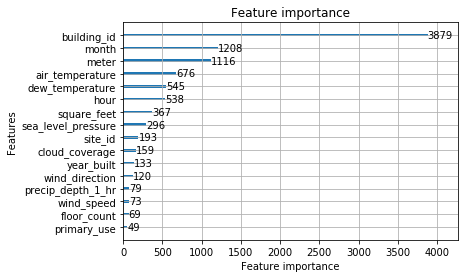

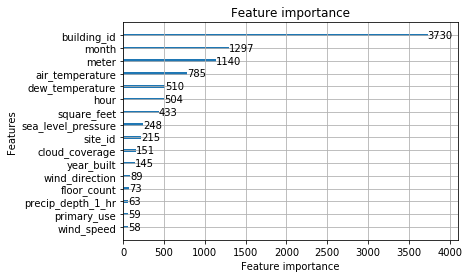

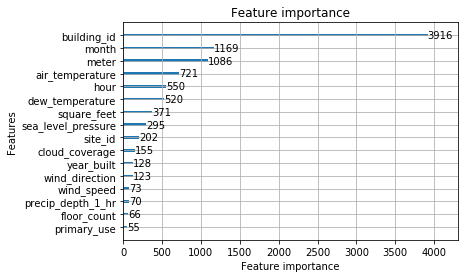

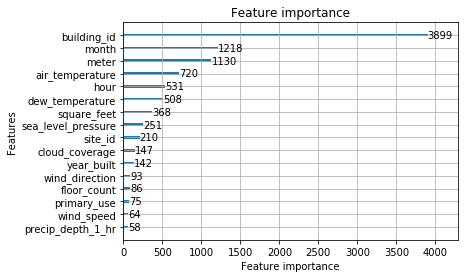

In [80]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [81]:
# Removing unnecessary dataframes
import gc
del train_final_df, train_X, val_X, lgb_train, lgb_eval, train_y, val_y, target
gc.collect()

16792

In [82]:
# Join the train and building dataframes
test_building_df = test_df.merge(building_meta_df, on=['building_id'], how='left')
test_building_df.shape

(41697600, 9)

In [83]:
test_building_df.isnull().sum()

row_id         0
building_id    0
meter          0
timestamp      0
site_id        0
primary_use    0
square_feet    0
year_built     0
floor_count    0
dtype: int64

In [84]:
# Fill the missing values using linear interpolation method in forward direction
weather_test_df.interpolate(method='linear', limit_direction='forward', inplace=True)
# Fill the missing values using linear interpolation method in backward direction
weather_test_df.interpolate(method='linear', limit_direction='forward', inplace=True)
test_final_df = test_building_df.merge(weather_test_df, on=['timestamp', 'site_id'], how='left')
test_final_df.shape

(41697600, 16)

In [85]:
test_final_df.isnull().sum()

row_id                     0
building_id                0
meter                      0
timestamp                  0
site_id                    0
primary_use                0
square_feet                0
year_built                 0
floor_count                0
air_temperature       199029
cloud_coverage        199029
dew_temperature       199029
precip_depth_1_hr     199158
sea_level_pressure    199029
wind_direction        199029
wind_speed            199029
dtype: int64

Plot-> weather_train_df and weather_test_df after interpolation to see, if the graphs are changed or not. Should not change.
Plot the distribution of all variables in both train and test. Get insights.
Understand results properly, and do feature engineering. 
What to do with outliers? Some buildings have very high meter value.

In [86]:
# Fill null values with 0
test_final_df.fillna(0, inplace=True)
test_final_df['primary_use'] = le.fit_transform(test_final_df['primary_use'])

In [87]:
test_final_df["timestamp"] = pd.to_datetime(test_final_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
test_final_df['month'] = test_final_df.timestamp.dt.month
test_final_df['hour'] = test_final_df.timestamp.dt.hour
test_final_df = test_final_df[feat_cols]

In [88]:
# Predictions
# Summing up all the model predictions, divided by folds, and then taking exponent followed by subtraction from 1.
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test_final_df.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(test_final_df.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size

100%|██████████| 834/834 [53:09<00:00,  3.82s/it]


In [89]:
res = np.concatenate(res)

In [90]:
submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
submission['meter_reading'] = res
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
submission.to_csv('submission.csv', index=False)